In [1]:
from pathlib import Path
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
from utils.data_extractors import *
from utils.visualizations import *
import seaborn as sns
from scipy.stats import sem
from scipy.signal import convolve2d

In [2]:
root = Path('results_rerun')
filters = {
    'buffer_size' : [10000],
    'env': ['envs:random_maze-v0', 'CartPole-v1']}

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)

10800it [04:08, 43.49it/s]


In [3]:
df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df = df.replace('FFN, 10', 'DQN')
df = df.replace('FFN, 1', 'DQN')

df = df.replace('RNN, 1', 'DRQN, 1')
df = df.replace('RNN, 2', 'DRQN, 2')
df = df.replace('RNN, 4', 'DRQN, 4')
df = df.replace('RNN, 8', 'DRQN, 8')

# df['params'] = df['Learning Freq.'] + ', ' + df['Target Update Freq.'] + ', ' + df['Step Size'] + ', ' + df['Buffer Size']

# df = df.drop(['Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'], axis=1)


In [5]:
df_mean = df.groupby(columns).mean().reset_index() # dataframe with mean over seeds for each parameter/alg/env configuration

# Total Number of episodes completed for all hyperparameters

In [6]:
colours = sns.color_palette()
c_dict = {}
algs = df_mean.Algorithm.unique()
for alg in algs:
    c_dict[alg] = colours.pop(0)
c_dict

{'DQN': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'DRQN, 1': (1.0, 0.4980392156862745, 0.054901960784313725),
 'DRQN, 2': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'DRQN, 4': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'DRQN, 8': (0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

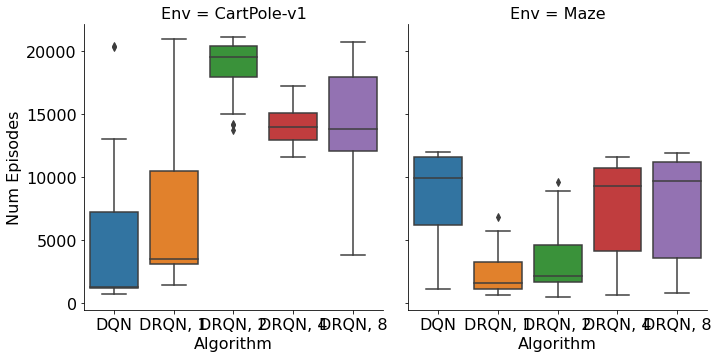

In [75]:
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df_mean, kind = 'box')
plt.savefig("sensitivity.pdf")

In [7]:
# Box plots of average number of episodes completed for all algorithms


for env in df_mean.Env.unique():
    g = sns.pointplot(x='Algorithm', y='Num Episodes', join=False, hue='params', data=df.loc[df['Env']==env], ci=68)
    g.set_title(env)
    g.set_ylabel("Number of Episodes Completed")
    # for i in range(0,5):
    #     mybox = g.artists[i]
    #     mybox.set_facecolor(c_dict[algs[i]])
    plt.legend([],[], frameon=False)
    g.set_xlabel("")
    g.set_xticklabels(g.get_xticklabels(),rotation=30)
    #g.set_xticklabels(rotation=30)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    #plt.savefig('figures/hyper_param_sensitivity_%s.pdf'%env, bbox_inches='tight')
    plt.show()
    #plt.title(env)
    #plt.clf()

ValueError: Could not interpret input 'params'

In [11]:
def n_best_params(df, env, alg, n, columns, metric, maximize=True):
    '''
    returns the n best hyperparameter of alg on env accroding to metric column in df
    if maximize = True then higher numbers are better
    '''
    df_env_alg = df.loc[(df['Env'] == env) & (df['Algorithm'] ==alg)] # filtered by env and alg
    if maximize:
        df_env_alg = df_env_alg.nlargest(n, metric)
    else:
        df_env_alg = df_env_alg.nsmallest(n, metric)

    df_env_alg = df_env_alg.set_index(columns)
    inds = df_env_alg.index.tolist()

    return inds

In [12]:
def get_best_data(df, df_mean, columns, metric):
    '''
    Filters a dataframe to only include data from the best hyperparameters, as determined by df_mean
    '''
    inds = []
    for env in df['Env'].unique():
        for alg in df['Algorithm'].unique():
            if env == 'CartPole-v1': # fewer episodes completed is better for cartpole
                maximize = False
            else:
                maximize = True

            inds += n_best_params(df_mean, env, alg, 1, columns, metric, maximize=maximize)
    
    df_ = df.set_index(columns)
    df_ = df_.loc[inds]
    return df_.reset_index(), inds

## Total Number of episodes completed for best hyperparameters

Maze


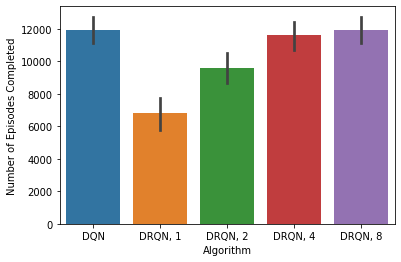

CartPole-v1


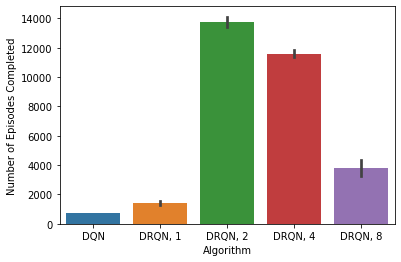

<Figure size 432x288 with 0 Axes>

In [15]:
df_best, best_inds = get_best_data(df, df_mean, columns, 'Num Episodes')

for env in df_best.Env.unique():
    
    print(env)
    g = sns.barplot(x='Algorithm', y='Num Episodes',  data=df_best.loc[df_best['Env']==env], ci=68)
    g.set_ylabel("Number of Episodes Completed")
    plt.show()
    plt.savefig('figures/total_episodes_best_params.pdf', bbox_inches='tight')

In [14]:
best_inds

[('DQN', 'Maze', '1', '10', '5e-05', '10000'),
 ('DRQN, 1', 'Maze', '1', '100', '0.005', '10000'),
 ('DRQN, 2', 'Maze', '1', '100', '0.0005', '10000'),
 ('DRQN, 4', 'Maze', '1', '1', '5e-05', '10000'),
 ('DRQN, 8', 'Maze', '1', '10', '5e-05', '10000'),
 ('DQN', 'CartPole-v1', '1', '100', '0.0005', '10000'),
 ('DRQN, 1', 'CartPole-v1', '10', '100', '0.005', '10000'),
 ('DRQN, 2', 'CartPole-v1', '10', '1000', '0.005', '10000'),
 ('DRQN, 4', 'CartPole-v1', '10', '10', '0.0005', '10000'),
 ('DRQN, 8', 'CartPole-v1', '10', '1000', '0.005', '10000')]

## average episode length for best hyperparameters last 50 episodes

In [22]:
best_inds = [('FFN', '1', 'envs:random_maze-v0', '1', '10', '5e-05', '10000'),
 ('RNN', '1', 'envs:random_maze-v0', '1', '100', '0.005', '10000'),
 ('RNN', '2', 'envs:random_maze-v0', '1', '100', '0.0005', '10000'),
 ('RNN', '4', 'envs:random_maze-v0', '1', '1', '5e-05', '10000'),
 ('RNN', '8', 'envs:random_maze-v0', '1', '10', '5e-05', '10000'),
 ('FFN', '1', 'CartPole-v1', '1', '100', '0.0005', '10000'),
 ('RNN', '1', 'CartPole-v1', '10', '100', '0.005', '10000'),
 ('RNN', '2', 'CartPole-v1', '10', '1000', '0.005', '10000'),
 ('RNN', '4', 'CartPole-v1', '10', '10', '0.0005', '10000'),
 ('RNN', '8', 'CartPole-v1', '10', '1000', '0.005', '10000')]

In [26]:
best_params = []
best_num_episodes = []
for i in best_inds:

    filters = { 
            'model_arch' : [i[0]],
            'env' : [i[2]],
            'learning_freq' : [int(i[3])],
            'target_update_freq' : [int(i[4])],
            'learning_rate' : [float(i[5])],
            'buffer_size' : [10000]
        }
    if i[0] == 'RNN':
        filters['seq_len'] = [int(i[1])]

    params_, num_episodes_ = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)

    best_params.append(params_)
    best_num_episodes.append(num_episodes_)


best_params = np.concatenate(best_params, axis=0)
best_num_episodes= np.concatenate(best_num_episodes, axis=0)


10800it [00:01, 6450.17it/s]
10800it [00:01, 6469.50it/s]
10800it [00:01, 6504.57it/s]
10800it [00:01, 6434.79it/s]
10800it [00:01, 6423.31it/s]
10800it [00:01, 6496.74it/s]
10800it [00:01, 6520.24it/s]
10800it [00:01, 6500.65it/s]
10800it [00:01, 6446.32it/s]
10800it [00:01, 6508.48it/s]


In [28]:
df1 = pd.DataFrame(best_params)
df2 = pd.DataFrame(best_num_episodes)
df_best = pd.concat([df1, df2], axis=1)
df_best.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df_best = df_best.drop(['Seed'],axis=1)
df_best['Algorithm'] = df_best['Model'] + ', ' + df_best['L'] 
df_best = df_best.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_best = df_best.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_best = df_best.replace('FFN, 10', 'DQN')
df_best = df_best.replace('FFN, 1', 'DQN')

df_best = df_best.replace('RNN, 1', 'DRQN, 1')
df_best = df_best.replace('RNN, 2', 'DRQN, 2')
df_best = df_best.replace('RNN, 4', 'DRQN, 4')
df_best = df_best.replace('RNN, 8', 'DRQN, 8')


In [40]:
def extract_episode_lengths(root: str, param_names: list, filters=None, cutoffs=None, last_n=False):
    """
    Extract epsiode lengths

    args
        root : directory where results are stored
        param_names : a list of parameters to extract for each run, stored in params.json 
        env: which environment to extract this for
    """
    def cutoff(episode_len, cutoff):
        new_episode_len = []
        current_len = 0
        for i in episode_len:
            current_len += i
            if i != cutoff: 
                new_episode_len.append(current_len)
                current_len = 0

        return new_episode_len

    all_episodes = []
    all_params = []

    for dir in tqdm(root.iterdir()):    
        params_file = dir/'params.json'               
        params = json.load(open(params_file))
        params_run  = [] # relevant parameters for a single run
        env = params['env']

        filter = False
        for p in param_names:
            params_run.append(params.get(p, None))
            value = params.get(p, None)
            
            if filters is not None:
                allowed_values = filters.get(p)
                if allowed_values is not None and value not in allowed_values:
                    filter = True

        if filter == False:
            all_params.append(params_run)
            episode_len = np.load(dir/"episode_lengths.npy")

            if cutoffs is not None:
                # add cut off episodes to subsequent
                episode_len = cutoff(episode_len, cutoffs[env])

            if last_n:

                all_episodes.append(np.array(episode_len[-last_n:]))
            else:
                all_episodes.append(np.array(episode_len))
    
    return np.array(all_params), np.array(all_episodes)

In [81]:
best_params = []
best_episode_lengths_ = []
for i in best_inds:

    filters = { 
        'model_arch' : [i[0]],
        'env' : [i[2]],
        'learning_freq' : [int(i[3])],
        'target_update_freq' : [int(i[4])],
        'learning_rate' : [float(i[5])],
        'buffer_size' : [10000]
        }
    if i[0] == 'RNN':
        filters['seq_len'] = [int(i[1])]

    params_, episode_lengths_ = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs, last_n=30)


    # if i[0] =='RNN' and i[2] =='envs:random_maze-v0' and i[1] == '1':
    #     print(episode_lengths_)

    best_params.append(params_)
    best_episode_lengths_.append(np.mean(episode_lengths_, axis=1))


best_params = np.concatenate(best_params, axis=0)
best_episode_lengths = np.concatenate(best_episode_lengths_, axis=0)

10800it [00:01, 5589.13it/s]
10800it [00:01, 5958.88it/s]
1016it [00:00, 5035.99it/s][[   16    16    16    16    16    16    16    16    21    16    16    16
     16    16    16    16    16    16    16    20    23    16    16    16
     16    16    16    16    16    16]
 [  837    67 22996 35849  5596   161  3586  1736    79  4618  1447   802
    502  2734  1268  1823  1199  5218   313  2978  1477   391  1808  1902
    781  1208   705  3055  1195  3303]
 [   88   392   150   191   181   328   398   188   135    71   100   115
     79   241   184   259  1093  1193 27602  6287  5425  1373  4994  3850
   2945   143 11593  1074  4698  9062]
 [   23    90    94    26    85    23   151    27    17    56    28    23
     29    16    44    23    17    26    17    26    16    16    27    37
     36    16    23    71    61    22]
 [    8     8     8    18     8     8     8     8     8    10     8     8
      8     8     8     8     8     8     8     8     8     8     8     8
      8     8     8

In [66]:
df1 = pd.DataFrame(best_params)
df2 = pd.DataFrame(best_episode_lengths)
df_best_last = pd.concat([df1, df2], axis=1)


df_best_last.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Average Episode Length']
df_best_last = df_best_last.drop(['Seed'],axis=1)
df_best_last['Algorithm'] = df_best_last['Model'] + ', ' + df_best_last['L'] 
df_best_last = df_best_last.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_best_last = df_best_last.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_best_last = df_best_last.replace('FFN, 10', 'DQN')
df_best_last = df_best_last.replace('FFN, 1', 'DQN')

df_best_last = df_best_last.replace('RNN, 1', 'DRQN, 1')
df_best_last = df_best_last.replace('RNN, 2', 'DRQN, 2')
df_best_last = df_best_last.replace('RNN, 4', 'DRQN, 4')
df_best_last = df_best_last.replace('RNN, 8', 'DRQN, 8')


In [67]:
df_best_last

,Env,Learning Freq.,Target Update Freq.,Step Size,Buffer Size,Average Episode Length,Algorithm
0,Maze,1,10,5e-05,10000,16.200000,DQN
1,Maze,1,10,5e-05,10000,16.200000,DQN
2,Maze,1,10,5e-05,10000,20.200000,DQN
3,Maze,1,10,5e-05,10000,20.133333,DQN
4,Maze,1,10,5e-05,10000,20.333333,DQN
...,...,...,...,...,...,...,...
295,CartPole-v1,10,1000,0.005,10000,66.166667,"DRQN, 8"
296,CartPole-v1,10,1000,0.005,10000,9.800000,"DRQN, 8"
297,CartPole-v1,10,1000,0.005,10000,11.166667,"DRQN, 8"
298,CartPole-v1,10,1000,0.005,10000,69.866667,"DRQN, 8"


In [68]:
df_temp = pd.concat([df_best_last.set_index(columns), df_best.set_index(columns)], axis=1)
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['Learning Freq.', 'Target Update Freq.',  'Step Size', 'Buffer Size'], axis=1)
df_temp = df_temp.melt(id_vars=['Algorithm', 'Env'], var_name = 'source', value_name='val')

30
30
30
30
30
30
30
30
30
30


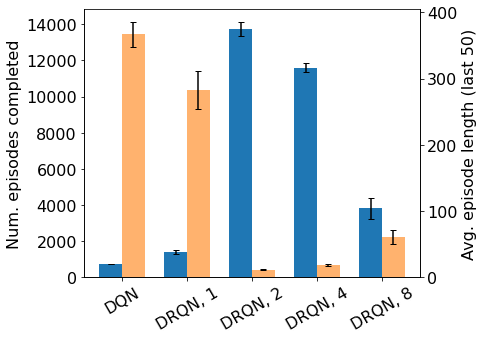

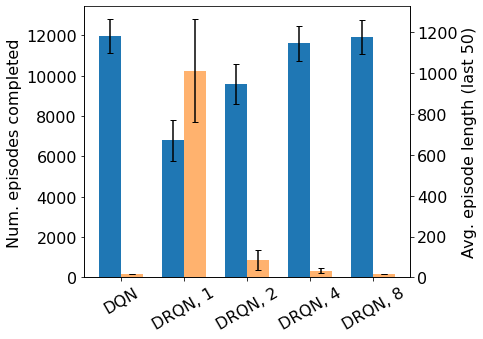

In [80]:
# double bar plot
font = {'size'   : 16}

matplotlib.rc('font', **font)
env_ind = 1

data = df_temp.values
algs =  np.unique(data[:, 0])
envs = np.unique(data[:, 1])

x = np.arange(len(algs))  # the label locations
width = 0.35  # the width of the bars

ax_idx = 0

sns.color_palette().as_hex()

for env in envs:
    num_subplots = envs.shape[0]
    fig, ax = plt.subplots(1, 1, figsize=(7,5))
    #ax = axs[0]
    data_num_episodes_to_plot = []
    data_ep_len_to_plot = []
    num_episodes_err = []
    ep_len_err = []
    scale = 1

    for alg in algs:
        data_num_episodes = data[np.where((data[:, 2] == 'Num Episodes') & (data[:, 1] ==env) & (data[:, 0] == alg))]
        data_ep_len = data[np.where((data[:, 2] == 'Average Episode Length') & (data[:, 1] ==env) & (data[:, 0] == alg))]       

        print(len(data_num_episodes[:, 3]))
        data_num_episodes_to_plot.append(np.mean(data_num_episodes[:, 3]))
        data_ep_len_to_plot.append(np.mean(data_ep_len[:, 3]* scale ))
        num_episodes_err.append(sem(data_num_episodes[:, 3]))
        ep_len_err.append(sem(data_ep_len[:, 3]))

    rects1 = ax.bar(x - width/2, data_num_episodes_to_plot, width, label='Overall Performance', color='tab:blue' )
    ax.errorbar(x - width/2, data_num_episodes_to_plot, yerr=num_episodes_err, ecolor='black', capsize=3, ls='none' )

    ax.set_ylabel('Num. episodes completed')
    #ax.set_title(env)
    ax.set_xticks(x)
    ax.set_xticklabels(algs, rotation=30)
    ax2 = ax.twinx()
    ax2.set_ylabel('Avg. episode length (last 50)')

    rects2 = ax2.bar(x + width/2, data_ep_len_to_plot, width, label='Final Performance', color='tab:orange', alpha = 0.6)
    ax2.errorbar(x + width/2, data_ep_len_to_plot, yerr=ep_len_err, ecolor='black', capsize=3, ls='none' )

    handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')
    plt.xticks(rotation=290)
    fig.gca().spines['top'].set_visible(False)
    fig.tight_layout()
    plt.savefig("figures/double_bar_30%s.pdf"%env, bbox_inches='tight')

In [73]:
best_params = []
best_episode_lengths_ = []
for i in best_inds:

    filters = { 
            'model_arch' : [i[0]],
            'env' : [i[2]],
            'learning_freq' : [int(i[3])],
            'target_update_freq' : [int(i[4])],
            'learning_rate' : [float(i[5])],
            'buffer_size' : [10000]
        }
    if i[0] == 'RNN':
        filters['seq_len'] = [int(i[1])]

    params_, episode_lengths_ = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)

    best_params.append(params_)
    best_episode_lengths_.append(episode_lengths_)


best_params = np.concatenate(best_params, axis=0)
best_episode_lengths = np.concatenate(best_episode_lengths_, axis=0)

df1 = pd.DataFrame(best_params)
df2 = pd.DataFrame(best_episode_lengths)
df_best_all_episodes = pd.concat([df1, df2], axis=1)


df_best_all_episodes.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Episode Lengths']
df_best_all_episodes = df_best_all_episodes.drop(['Seed'],axis=1)
df_best_all_episodes['Algorithm'] = df_best_all_episodes['Model'] + ', ' + df_best_all_episodes['L'] 
df_best_all_episodes = df_best_all_episodes.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_best_all_episodes = df_best_all_episodes.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_best_all_episodes = df_best_all_episodes.replace('FFN, 10', 'DQN')
df_best_all_episodes = df_best_all_episodes.replace('FFN, 1', 'DQN')

df_best_all_episodes = df_best_all_episodes.replace('RNN, 1', 'DRQN, 1')
df_best_all_episodes = df_best_all_episodes.replace('RNN, 2', 'DRQN, 2')
df_best_all_episodes = df_best_all_episodes.replace('RNN, 4', 'DRQN, 4')
df_best_all_episodes = df_best_all_episodes.replace('RNN, 8', 'DRQN, 8')

10800it [00:01, 5583.03it/s]
10800it [00:01, 5846.01it/s]
10800it [00:01, 5740.35it/s]
10800it [00:01, 5588.81it/s]
10800it [00:01, 5685.93it/s]
10800it [00:01, 6579.88it/s]
10800it [00:01, 6381.55it/s]
10800it [00:01, 5494.96it/s]
10800it [00:01, 5673.95it/s]
10800it [00:01, 6212.65it/s]
C:\Users\Revan MacQueen\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


[5896, 4421, 4968, 3954, 2838, 3195, 10456, 14412, 1122, 4115, 953, 3587, 2146, 10175, 10363, 6935, 1008, 1246, 11770, 3318, 3141, 10951, 1048, 1064, 12811, 1412, 20669, 10585, 1263, 1012, 5077, 9921, 12402, 4137, 2051, 5059, 5619, 1123, 5215, 2633, 2883, 4771, 16803, 19916, 22996, 2847, 3742, 2355, 3611, 4159, 15573, 4867, 24448, 2248, 30973, 27602, 35849, 12500, 5775, 5768, 6836, 2098, 3752, 2635, 9574, 2722, 2365, 9800, 5235, 6287, 2631, 8359, 7852, 28925, 5596, 4994, 15071, 3881, 15084, 4618, 12694, 11593, 8575, 22916, 7423, 1823, 6652, 5218, 11594, 5531, 9062, 2850, 4514, 12048, 2923, 6340, 3691, 3303, 2472, 1546]
<ipython-input-86-7cbf61d2db37>:43: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', basey=2)


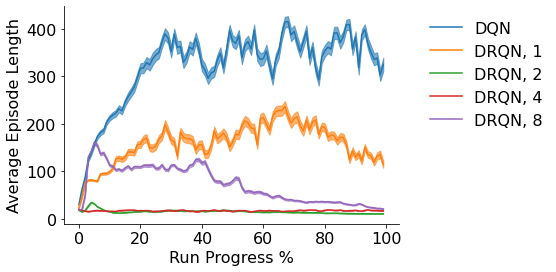

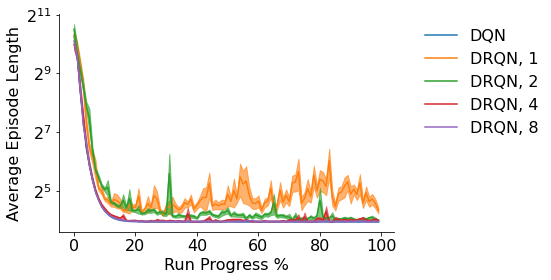

In [86]:
'''
Bins episode lengths in each run into 100 bins and then creates learning curves,
averaging across the corresponding bins for all 100 runs of the best parameter settings
'''    


envs = ['CartPole-v1', 'Maze']
for env in envs:
    algs = []
    plt.figure()
    ax = plt.gca()
    for alg in df_best_all_episodes.Algorithm.unique():
        algs.append(alg)
        df_DRQN4 = df_best_all_episodes.loc[(df_best_all_episodes['Env'] == env) & (df_best_all_episodes['Algorithm'] == alg)]
        data = df_DRQN4['Episode Lengths'].values
        n_bins = 100
        bin_size = 200000/n_bins
        bins = [[] for i in range(n_bins)]

        for run in data:
            sum_ = 0
            for i, ep_len in enumerate(run):
                ind = int(sum_ // bin_size)  # which bin to place data (based on start time)
                bins[ind].append(ep_len)
                sum_ += ep_len 
        
        if alg =='DRQN, 1' and env=='Maze':
            print([np.max(i) for i in bins])



        mean = np.array([ np.sum(i)/len(i) for i in bins])
        sigma = np.array([np.std(i,axis=0)/np.sqrt(len(i)) for i in bins])
        t = np.linspace(0, n_bins-1, n_bins)
        plt.plot(mean, color=c_dict[alg])
        ax.fill_between(t, mean+sigma, mean-sigma, alpha=0.6, color=c_dict[alg])

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Run Progress %')
    plt.ylabel('Average Episode Length')
    if env == 'Maze':
        plt.yscale('log', basey=2)

    plt.legend(algs, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    plt.savefig('figures/learning_curve_best_%s.pdf'%env, bbox_inches='tight')